# OpenStreetMap - Freiburg - Project Description

The goal for this project was to use data munging techniques to wrangle a dataset from the [OpenStreetMap database](https://www.openstreetmap.org/). For the project I downloaded a sample size of the city of Freiburg in southern Germany. I selected Freiburg because I am currently living in Freiburg have been living here for a couple of years. 
You can find the link for the Freiburg map [here](https://www.openstreetmap.org/export#map=15/47.9916/7.8517). The subsample of this map can be found [here](https://www.openstreetmap.org/export#map=17/47.98827/7.86662). 

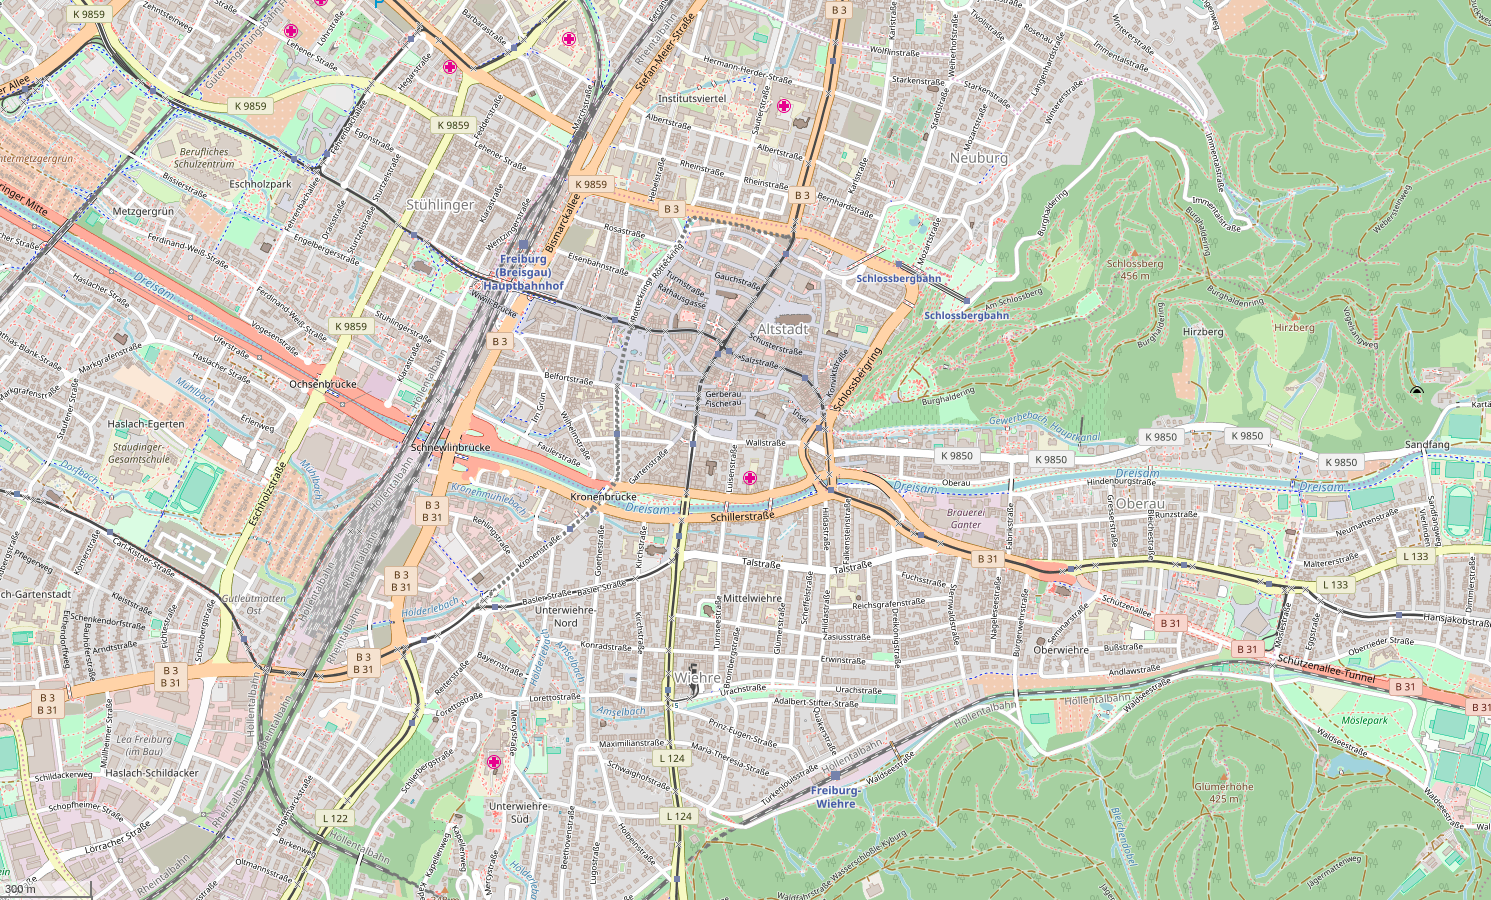

In [4]:
from IPython.display import Image
Image("freiburg.png")

## Data auditing, cleaning, and problems encountered in the map

You can find the corresponding python script for this part of the documentation in `scripts/osm_to_mongo.py`

### Data auditing and cleaning

**Size of full map (freiburg.osm)**:   87MB

**Size of map sample (freiburg_sample.osm)**: 3.6MB

Before I wrote any code I tried to understand the overall structure of the osm document. The document turned out to be structured to a few important parent nodes. Luckily, the OpenStreetMap community has provided users with a thorough documentation on these importat parent nodes: [node](https://wiki.openstreetmap.org/wiki/Node), [way](https://wiki.openstreetmap.org/wiki/Way). Let's start with the nodes. A node indicates a specific location on the map. For example, a node could be a bench or a supermarket. Hence, nodes always have a longitute and latitude.

I decided to write a class to audit the data. The class has three methods:

1. **count_tags**: Counts the tags in the dataset (e.g., nodes, ways, and relations)
2. **parse**: Parses the data according to the specific element.
3. **__insert_into_collection**: A helperfunction that inserts every element dynamically during parsing. I chose to insert the elements dynamically in order to avoid RAM issues.

The OSM class is doing all the audit work and it's main function is to insert the data into the mongo database. 

#### Convert xml to json format

As xml was not the best representational format for the data I converted each element to the following structure: 

In [ ]:
{
    "id": "2406124091",
    "type: "node",
    "visible":"true",
    "created": {
              "version":"2",
              "changeset":"17206049",
              "timestamp":"2013-08-03T16:43:42Z",
              "user":"linuxUser16",
              "uid":"1219059"
            },
    "pos": [41.9757030, -87.6921867],
    "address": {
              "housenumber": "5157",
              "postcode": "60625",
              "street": "North Lincoln Ave"
            },
    "amenity": "restaurant",
    "cuisine": "mexican",
    "name": "La Cabana De Don Luis",
    "phone": "1 (773)-271-5176"
}

This structure turned out to be much more readable and additionally had the benefit that common items are subsumed under a single key (e.g., address). 

#### Create nested nodes for common tags

Some nodes are nested. They have additional tags which incorporate a key and a value. For example, a node might contain a tag with the key *highway* and a value *turning_cirlce*. It turned out that some nodes have a special format. These nodes include a colon (**:**) indicating a relationship between them. For example, there is a tag with the common key string **fuel:**. I chose to combine these common tags into a single json key:

In [ ]:
if regex_colon.search(tag.attrib['k']) and tag.tag == "tag":

    splitted = re.split(':', tag.attrib['k'])

    # Insert key if non-existent
    if splitted[0] not in element_to_insert:
        element_to_insert[splitted[0]] = {}

        # Create nested dictionary if non-existent
        if splitted[1] not in element_to_insert[splitted[0]]:
            element_to_insert[splitted[0]][splitted[1]] = {}

        # Add information of sub dictionary
        element_to_insert[splitted[0]][splitted[1]] = \
            tag.attrib['v'].replace('.', '_')
# Other key information
else:
    element_to_insert[tag.attrib['k'].replace('.', '_')] = \
        tag.attrib['v'].replace('.', '_')

Hence:

In [ ]:
 <node id="24976931" lat="47.9883409" lon="7.8662851" version="13" timestamp="2012-12-18T18:27:56Z" changeset="14321886" uid="677817" user="franzmh">
    <tag k="amenity" v="fuel"/>
    <tag k="atm" v="yes"/>
    <tag k="atm:operator" v="Postbank"/>
    <tag k="brand" v="Shell"/>
    <tag k="fuel:GTL_diesel" v="yes"/>
    <tag k="fuel:biodiesel" v="no"/>
    <tag k="fuel:diesel" v="yes"/>
    <tag k="fuel:octane_100" v="yes"/>
    <tag k="fuel:octane_98" v="no"/>
    <tag k="opening_hours" v="24/7"/>
    <tag k="operator" v="Shell"/>
    <tag k="shop" v="kiosk"/>
  </node>

would convert to ...

In [ ]:
 [{'type': node',
  {'fuel': 
     {'GTL_diesel': 'yes',
      'biodiesel': 'no',
      'diesel': 'yes',
      'octane_100': 'yes',
      'octance_98': 'no'}
   ...]

#### Combine ref in way to list

When I inspected the osm file I could also see that the node, way and relation elements have a different structure. A way element has fewer tags and always included a **nd** subtag. Every **nd** subtag corresponds to a specific location which is part of the current way. As these subtags are semantically related I chose to put them into a common list. Hence:

  <way id="93213849" version="2" timestamp="2014-06-18T03:09:00Z" changeset="22996471" uid="152744" user="skyper">
    <nd ref="1080563152"/>
    <nd ref="1080563046"/>
    <nd ref="1080563440"/>
    <nd ref="1080563218"/>
    <nd ref="1080563128"/>
    <nd ref="1080563467"/>
    <nd ref="1080563095"/>
    <nd ref="1080563152"/>
    <tag k="building:part" v="yes"/>
    <tag k="source" v="Bing 2011"/>
  </way>

would convert to

In [ ]:
'node_refs': ['1080563152', '1080563046', '1080563440', ...]

#### Clean malformed keys

Some keys were malformed since different keys were used for the same content. For example there was `contact:email` and an `email` keys. Both keys obviously refer to the same entity. To avoid this problem I converted each email to the string **email**:  

In [ ]:
def __clean_key__(self, current_key):
    """Cleans malformed keys and returns cleaned key"""

    # Conditions for cleaning
    rep = {"contact:email": "email",
           "contact:phone": "phone",
           "contact:website": "website",
           ".": "_"}

    # Regex to replace according to condition
    rep = dict((re.escape(k), v) for k, v in rep.items())
    pattern = re.compile("|".join(rep.keys()))

    # Create new key
    new_key = pattern.sub(lambda m: rep[re.escape(m.group(0))], current_key)

    return new_key

The same behavior applied to keys related to phone numbers and websites:

`contact:phone` ->`phone`

`contact:website` -> `website`

Some keys resulted in errors when I inserted the data into the mongodb database. These keys involved a dot (`.`). Hence, I replaced each dot with an underscore sign (see code above).

#### Malformed urls

There were also some malformed urls. A malformed url did not have a scheme: `www.sport-kiefer.de`. In order to standardise the urls I added a scheme to all non-scheme websites:

In [ ]:
def __clean_value__(self, current_value):
    """Clean malformed values and return cleaned value"""

    new_value = current_value

    # We found a malformed url
    if new_value.startswith('www'):
        new_value = 'http://' + new_value
        print(new_value)

    return new_value

As a results, the conversion looked like this:

`www.sport-kiefer` ->`http://www.sport-kiefer`

`www.wodan-halle-freiburg.de` -> `http://www.wodan-halle-freiburg.de`

`www.freiburger-tafel.de` -> `http://www.freiburger-tafel.de`

### Problems

#### Don't repeat yourself

As I wrote the \__insert_into_collection\__ function for the OSMClass I first tried to create a single element_to_insert dictionary for each node, way and relation. This idea seemed to be counterproductive as every node shared common keys. I therefore decided to create one element_to_insert dictionary at the beginning of the method and added element specific tags afterwards. This results in a much cleaner code:

In [ ]:
element_to_insert = {
    "id": attrib['id'],
    "type": element.tag,
    "visible": "true",
    "created": {
        "version": attrib['version'],
        "changeset": attrib['changeset'],
        "user": attrib['user'].replace('.', '_'),
        "uid": attrib['uid']
    }}

# Add position if tag == node
if element.tag == "node":
    element_to_insert["pos"] = [float(attrib.get('lon', None)),
                float(attrib.get('lat', None))]

#### Error in insert_one function 

I wanted to add every element dynamically to the mongo database as I parsed the document. It turned out that a dot (**.**) lead to an error and I coulnd't insert values with a dot. In order to avoid this problem I replaced each dot in a value with an underscore: `attrib['user'].replace('.', '_')`.  

#### TypeError: k does not exist

First, I assumed that every element that has a subtag of tag also has a **k and v attribute**. It turned out that this behavior applies to nodes but not to ways or relations. Hence, I decided to add a catch statement that would ignore computations that deal with k and v attributes if they are non-existent for the particular tag: 

In [ ]:
# Loop over every tag in element
for tag in element:
    # Some tags do not contain a k element
    # avoid them
    ...
    except KeyError:
        pass

## Overview of the data

You can find the corresponding python script for this part of the documentation in `scripts/queries.py`

In [127]:
from pymongo import MongoClient
from bson.son import SON
import collections

In [62]:
# Open mongodb
client = MongoClient('localhost:27017')
db = client.elements

### How many elements does the dataset contain? 

In [48]:
print("Nodes: {}".format(db.nodes.count()))
print("Ways: {}".format(db.ways.count()))
print("Relations: {}".format(db.relations.count()))

Nodes: 333959
Ways: 64160
Relations: 2138


### Who are the users in the dataset? 

In [81]:
# How many users contributed to the map
users_nodes = db.nodes.distinct('created.user')
users_ways = db.ways.distinct('created.user')
users_relations = db.relations.distinct('created.user')

users = users_nodes + users_ways + users_relations

print("{} users contributed to the map".format(len(set(users))))

814 users contributed to the map


In [85]:
# Most popular users for nodes
pipeline = [
    {"$unwind": "$created"},
    {"$unwind": "$created.user"},
    {"$group": {"_id": "$created.user", "count": {"$sum": 1}}},
    {"$sort": SON([("count", -1), ("_id", -1)])}
]

most_popular_keys = list(db.nodes.aggregate(pipeline))[1:10]

for index, top_user in enumerate(most_popular_keys):
    print("{}. {} contributed {} elements".format(index + 1, most_popular_keys[index]["_id"], most_popular_keys[index]["count"]))

1. skyper contributed 76483 elements
2. malta-dinger contributed 5392 elements
3. release_candidate contributed 5222 elements
4. mgoe contributed 5006 elements
5. rurseekatze contributed 4330 elements
6. daloop contributed 3129 elements
7. ferrero2 contributed 3035 elements
8. dddos contributed 2403 elements
9. Tronikon contributed 1906 elements


### What are the most important amenities?

In [98]:
pipeline = [
    {"$unwind": "$amenity"},
    {"$group": {"_id": "$amenity", "count": {"$sum": 1}}},
    {"$sort": SON([("count", -1), ("_id", -1)])}
]

most_important_amenities = list(db.nodes.aggregate(pipeline))[1:10]

for index, top_amenity in enumerate(most_important_amenities):
    print("{}. {} occurs {} times".format(index + 1, top_amenity["_id"], top_amenity["count"]))

1. vending_machine occurs 225 times
2. parking occurs 222 times
3. restaurant occurs 218 times
4. recycling occurs 182 times
5. bicycle_parking occurs 181 times
6. cafe occurs 143 times
7. waste_basket occurs 141 times
8. telephone occurs 130 times
9. post_box occurs 103 times


### How many asian restaurants does the map contain? 

In [108]:
# What are the most common amenities
amenities = db.nodes.find({'cuisine': 'asian', 'amenity': 'restaurant'})

print("There are {} asian restaurants".format(amenities.count()))

for amenity in amenities:
    print("{}".format(amenity['name']))

There are 7 asian restaurants
Mekong
Oishii
Wok & Roll
Thai Chi
Mai-Wok
Asia House
Mai Garden


### How many places are accessible for wheelchair users?

In [120]:
non_accessible = db.nodes.find({'wheelchair': 'yes'}).count()
accessible     = db.nodes.find({'wheelchair': 'no'}).count()

print("{} % of places are accessible for wheelchair users".format(round(accessible / (float(accessible) + non_accessible), 4) * 100))

31.21 % of places are accessible for wheelchair users


## Additional ideas about the dataset

### Bicycle shops

Freiburg is a city with numerous bicycles. Since bicycles have to be serviced regularly, there should be enough bicycle shops. And indeed, there are plenty of them in Freiburg:

In [126]:
bicycle_shops = db.nodes.find({'shop': 'bicycle'})

print("There are {} bicycle shops in Freiburg".format(bicycle_shops.count()))

There are 37 bicycle shops in Freiburg


It would be interesting to know how the bicycle shops are distributed on the map. Some areas in Freiburg might need a more dense concentration of bicycle shops than others. If for example you want to start a new bicycle shop you should find places with few bicycle shops that also have a need for bicycle services. Yet, finding out if a new bicycle shop is reasonable requires a lot of expertise in business administration. However, low-density areas might still be a good place to start a bicycle shop.


### Double checking of the data

Since everyone can contribute to the map, errors have to occur. For example, some users might accidentally indicate that a restaurant is accessible for wheelchair users. I would therefore suggest that new elements have to be confirmed by other users first. Due to such a peer-review process, many errors might be avoided. On the other hand double checking would cause a certain delay in the map. As a consequence specific locations might not be as up-to-date as it could be. So there is a tradeoff between accuracy and speed. This is especially pressing as other vendors such as Google provide maps that are usually very up-to-date. 


## References 

* [xml.etree.cElementTree](https://docs.python.org/2/library/xml.etree.elementtree.html#)
* [clementtree](http://www.effbot.org/zone/celementtree.htm#usage)
* https://wiki.openstreetmap.org/wiki/Node
* https://wiki.openstreetmap.org/wiki/Way
* https://github.com/pratyush19/Udacity-Data-Analyst-Nanodegree/blob/master/P3-OpenStreetMap-Wrangling-with-SQL/query.py
* https://github.com/iandees/mongosm/blob/master/insert_osm_data.py
* https://stackoverflow.com/questions/6116978/how-to-replace-multiple-substrings-of-a-string
* https://stackoverflow.com/questions/25259134/how-can-i-check-whether-a-url-is-valid-using-urlparse